# Active Learning on the Support Vector Machine classifier

Now that the data is preprocessed we can start with our actual experiments.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import pipeline, preprocessing

%load_ext autoreload
%autoreload 2
from Methods import *

First we need to read in the dataframe where we categorize the target in numbers and get the input features and labels

In [4]:
#read in dataframe
data = pd.read_csv('dataset_1.csv')

#define the target and categorize it in numbers
target = 'PROFILE'
profile_options = np.unique(data['PROFILE'])
for index, profile in enumerate(profile_options):
    data.loc[data['PROFILE'] == profile,'PROFILE'] = index

#then get your input features and labels
X = np.array(data.drop(target, axis=1).values.tolist())
y_true = np.array(data[target]).astype('int')

### 1-2) Applying cross-validation on the classifier without tuning the hyperparameters

In [5]:
def cross_validation(X, y, folds, clf):
    skf = StratifiedKFold(n_splits=folds)
    bal_accs = []
    for i, (train_index, test_index) in enumerate(skf.split(X,y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        bal_acc = balanced_accuracy(y_pred, y_test)
        bal_accs.append(bal_acc)
    print(f"Avg balanced accuracy: {np.mean(bal_accs):.3f}")
    print()

In [6]:
print('SVM')
clf = pipeline.Pipeline([('sc', StandardScaler()), 
                         ('svm', SVC())])
cross_validation(X, y_true, 5, clf)

SVM
Avg balanced accuracy: 0.919



### 3) Tuning the Hyperparameters
TO DO: normaal de nested_cv gebruiken maar kan nog geen best parameters printen

In [7]:
def grid_search(X, y, model, p_grid):
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    clf = GridSearchCV(estimator=model, param_grid=p_grid, scoring="balanced_accuracy", cv=cv)
    clf.fit(X, y)
    print(f"Best score: {clf.best_score_:.4f}")
    print(f"Best params: {clf.best_params_}")
    return clf.best_params_
    
def nested_cv(X, y, model, p_grid):
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    
    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X, y, cv=outer_cv)
    return nested_score.mean()

In [9]:
print("Suport Vector Machine")
clf = pipeline.make_pipeline(StandardScaler(), SVC(random_state=0))
#print(SVC.get_params().keys())
best_param_dt = grid_search(X, y_true, clf, {"svc__kernel": ['linear', 'rbf', 'poly'], "svc__C": [1, 10, 100]})

Suport Vector Machine
Best score: 0.9300
Best params: {'svc__C': 10, 'svc__kernel': 'rbf'}


### 4) Splitsing in Training and Testing set

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y_true,test_size = 0.25)

In [11]:
print('Length of the training set: '+str(len(X_train)))

Length of the training set: 2250


### 5) Apply Active Learning
Daarvoor normaliseren we eerst de data

In [16]:
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
def plot_AL(cycle, accuracies, qs_name, clf_name):
    plt.plot(cycle, accuracies, label = qs_name)
    plt.xlabel('Labeled samples')
    plt.ylabel('Accuracy')
    plt.title(clf_name)
    plt.legend()
    plt.show()

Support Vector Machine


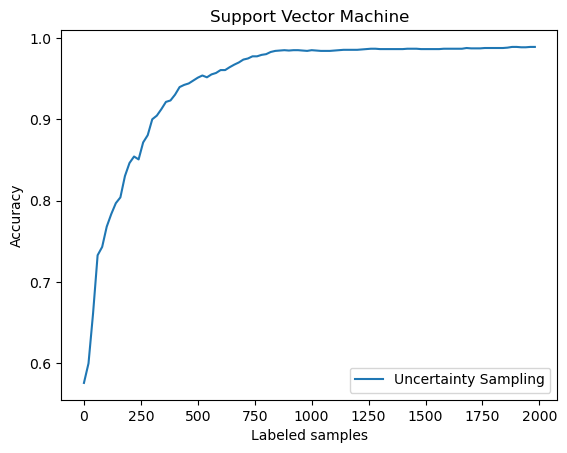

In [18]:
print('Support Vector Machine')
clf = SklearnClassifier(SVC(kernel = 'rbf', C = 10, probability = True), classes=np.unique(y_true))
clf_name = 'Support Vector Machine'
qs = UncertaintySampling(method='entropy')
qs_name = 'Uncertainty Sampling'
cycle, accuracies, indep_accuracies = ActiveLearning_UncertaintySampling(X_train_scaled, X_test_scaled, y_train, y_test, 100, 20, clf)
plot_AL(cycle, accuracies, qs_name, clf_name)

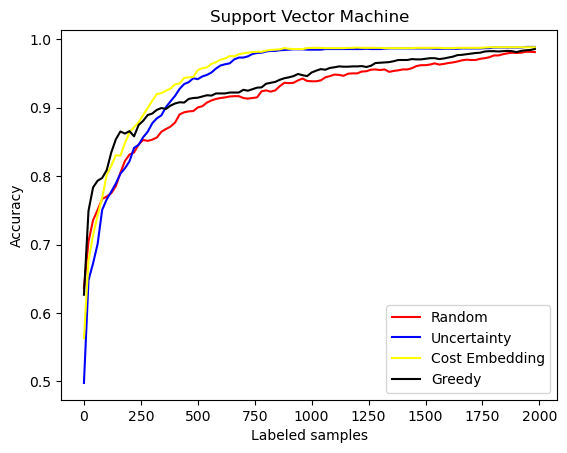

In [20]:
clf_name = 'Support Vector Machine'
colors = ['blue', 'red', 'green']

clf = SklearnClassifier(SVC(kernel = 'rbf', C = 10, probability = True), classes=np.unique(y_true))
cycle, accuracies, indep_accuracies = ActiveLearning_RandomSampling(X_train_scaled, X_test_scaled, y_train, y_test, 100, 20, clf)
plt.plot(cycle, accuracies, color = 'red', label = 'Random')
clf = SklearnClassifier(SVC(kernel = 'rbf', C = 10, probability = True), classes=np.unique(y_true))
cycle, accuracies, indep_accuracies = ActiveLearning_UncertaintySampling(X_train_scaled, X_test_scaled, y_train, y_test, 100, 20, clf)
plt.plot(cycle, accuracies, color = 'blue', label = 'Uncertainty')
#clf = SklearnClassifier(SVC(kernel = 'rbf', C = 10, probability = True), classes=np.unique(y_true))
#cycle, accuracies, indep_accuracies = ActiveLearning_QueryByCommittee(X_train_scaled, X_test_scaled, y_train, y_test, 100, 20, clf)
#plt.plot(cycle, accuracies, color = 'green', label = 'QBC')
clf = SklearnClassifier(SVC(kernel = 'rbf', C = 10, probability = True), classes=np.unique(y_true))
cycle, accuracies, indep_accuracies = ActiveLearning_CostEmbeddingAL(X_train_scaled, X_test_scaled, y_train, y_test, 100, 20, clf)
plt.plot(cycle, accuracies, color = 'yellow', label = 'Cost Embedding')
clf = SklearnClassifier(SVC(kernel = 'rbf', C = 10, probability = True), classes=np.unique(y_true))
cycle, accuracies, indep_accuracies = ActiveLearning_GreedySamplingX(X_train_scaled, X_test_scaled, y_train, y_test, 100, 20, clf)
plt.plot(cycle, accuracies, color = 'black', label = 'Greedy')

plt.xlabel('Labeled samples')
plt.ylabel('Accuracy')
plt.title(clf_name)
plt.legend()
plt.show()